<a href="https://colab.research.google.com/github/Esandu-Meth-Obadaarachchi/HCHO-level-Time-series-forecasting/blob/main/DE_3_Analysis_and_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.15.0


In [13]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8807170e83a0272a3d042ecd5ed13460e088d3c104a66f793b804896089a432e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [14]:
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, regexp_replace, when
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

In [5]:
from google.colab import drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
colombo_csv_path = '/content/drive/MyDrive/data engineering CW/colombo_df.csv'
deniyaya_matara_csv_path = '/content/drive/MyDrive/data engineering CW/deniyaya_matara_df.csv'
nuwara_eliya_csv_path = '/content/drive/MyDrive/data engineering CW/nuwara_eliya_df.csv'
bibile_monaragala_csv_path = '/content/drive/MyDrive/data engineering CW/bibile_monaragala_df.csv'
kurunegala_csv_path = '/content/drive/MyDrive/data engineering CW/kurunegala_df.csv'
jaffna_csv_path = '/content/drive/MyDrive/data engineering CW/jaffna_df.csv'
kandy_csv_path = '/content/drive/MyDrive/data engineering CW/kandy_df.csv'

In [15]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [16]:
colombo_df = spark.read.csv(colombo_csv_path,header = True)
deniyaya_matara_df = spark.read.csv(deniyaya_matara_csv_path,header = True)
nuwara_eliya_df = spark.read.csv(nuwara_eliya_csv_path,header = True)
bibile_monaragala_df = spark.read.csv(bibile_monaragala_csv_path,header = True)
jaffna_df = spark.read.csv(jaffna_csv_path,header = True)
kandy_df = spark.read.csv(kandy_csv_path ,header = True)
kurunegala_df=spark.read.csv(kurunegala_csv_path,header = True)

In [17]:
jaffna_df=jaffna_df.toPandas()
kandy_df=kandy_df.toPandas()
kurunegala_df=kurunegala_df.toPandas()
nuwara_eliya_df=nuwara_eliya_df.toPandas()
deniyaya_matara_df=deniyaya_matara_df.toPandas()
bibile_monaragala_df=bibile_monaragala_df.toPandas()
colombo_df=colombo_df.toPandas()

In [18]:

# Set index to 'Current Date'
colombo_df.set_index('Current Date', inplace=True)
deniyaya_matara_df.set_index('Current Date', inplace=True)
nuwara_eliya_df.set_index('Current Date', inplace=True)
bibile_monaragala_df.set_index('Current Date', inplace=True)
kurunegala_df.set_index('Current Date', inplace=True)
jaffna_df.set_index('Current Date', inplace=True)
kandy_df.set_index('Current Date', inplace=True)

In [19]:
colombo_df.head()

,Location,Next Date,HCHO reading
Current Date,,,
2019-01-01,Colombo Proper,2019-01-02,1.9698343957810148E-4
2019-01-02,Colombo Proper,2019-01-03,2.6255221719685945E-4
2019-01-03,Colombo Proper,2019-01-04,9.852118897938794E-5
2019-01-04,Colombo Proper,2019-01-05,2.099320518114242E-4
2019-01-05,Colombo Proper,2019-01-06,1.7853372988929305E-4


In [23]:
import pandas as pd

# File paths for each DataFrame CSV file
colombo_full_csv_path = '/content/drive/MyDrive/data engineering CW/colombo_df_full.csv'
deniyaya_matara_full_csv_path = '/content/drive/MyDrive/data engineering CW/deniyaya_matara_df_full.csv'
nuwara_eliya_full_csv_path = '/content/drive/MyDrive/data engineering CW/nuwara_eliya_df_full.csv'
bibile_monaragala_full_csv_path = '/content/drive/MyDrive/data engineering CW/bibile_monaragala_df_full.csv'
kurunegala_full_csv_path = '/content/drive/MyDrive/data engineering CW/kurunegala_df_full.csv'
jaffna_full_csv_path = '/content/drive/MyDrive/data engineering CW/jaffna_df_full.csv'
kandy_full_csv_path = '/content/drive/MyDrive/data engineering CW/kandy_df_full.csv'

# Load each DataFrame from the CSV file
colombo_df = pd.read_csv(colombo_full_csv_path, header=0, index_col=0)
deniyaya_matara_df = pd.read_csv(deniyaya_matara_full_csv_path, header=0, index_col=0)
nuwara_eliya_df = pd.read_csv(nuwara_eliya_full_csv_path, header=0, index_col=0)
bibile_monaragala_df = pd.read_csv(bibile_monaragala_full_csv_path, header=0, index_col=0)
kurunegala_df = pd.read_csv(kurunegala_full_csv_path, header=0, index_col=0)
jaffna_df = pd.read_csv(jaffna_full_csv_path, header=0, index_col=0)
kandy_df = pd.read_csv(kandy_full_csv_path, header=0, index_col=0)

In [24]:
# Set index to 'Current Date'
colombo_df.set_index('Current Date', inplace=True)
deniyaya_matara_df.set_index('Current Date', inplace=True)
nuwara_eliya_df.set_index('Current Date', inplace=True)
bibile_monaragala_df.set_index('Current Date', inplace=True)
kurunegala_df.set_index('Current Date', inplace=True)
jaffna_df.set_index('Current Date', inplace=True)
kandy_df.set_index('Current Date', inplace=True)

In [25]:
colombo_df.head()

,Location,Next Date,HCHO reading,Specific Humidity,Relative Humidity,Precipitation,Temperature,Skin Temperature
Current Date,,,,,,,,
2019-01-01,Colombo Proper,2019-01-02,0.000197,15.62,80.00,0.12,24.80,25.29
2019-01-02,Colombo Proper,2019-01-03,0.000263,15.14,79.50,0.02,24.39,25.01
2019-01-03,Colombo Proper,2019-01-04,0.000099,14.77,78.50,0.01,24.17,24.73
2019-01-04,Colombo Proper,2019-01-05,0.000210,14.47,77.62,0.00,24.04,24.57
2019-01-05,Colombo Proper,2019-01-06,0.000179,16.05,81.50,0.03,24.87,25.33


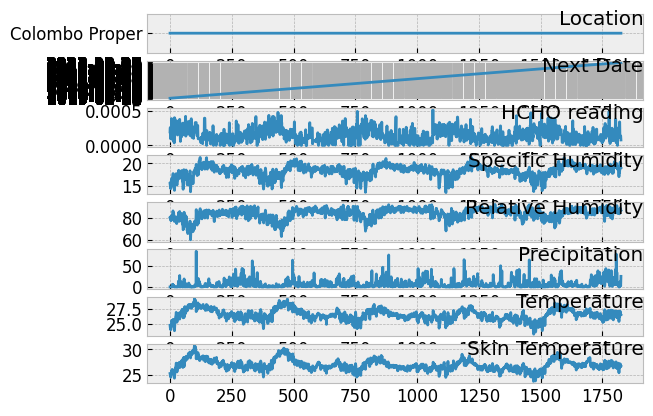

In [26]:
values = colombo_df.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(colombo_df.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

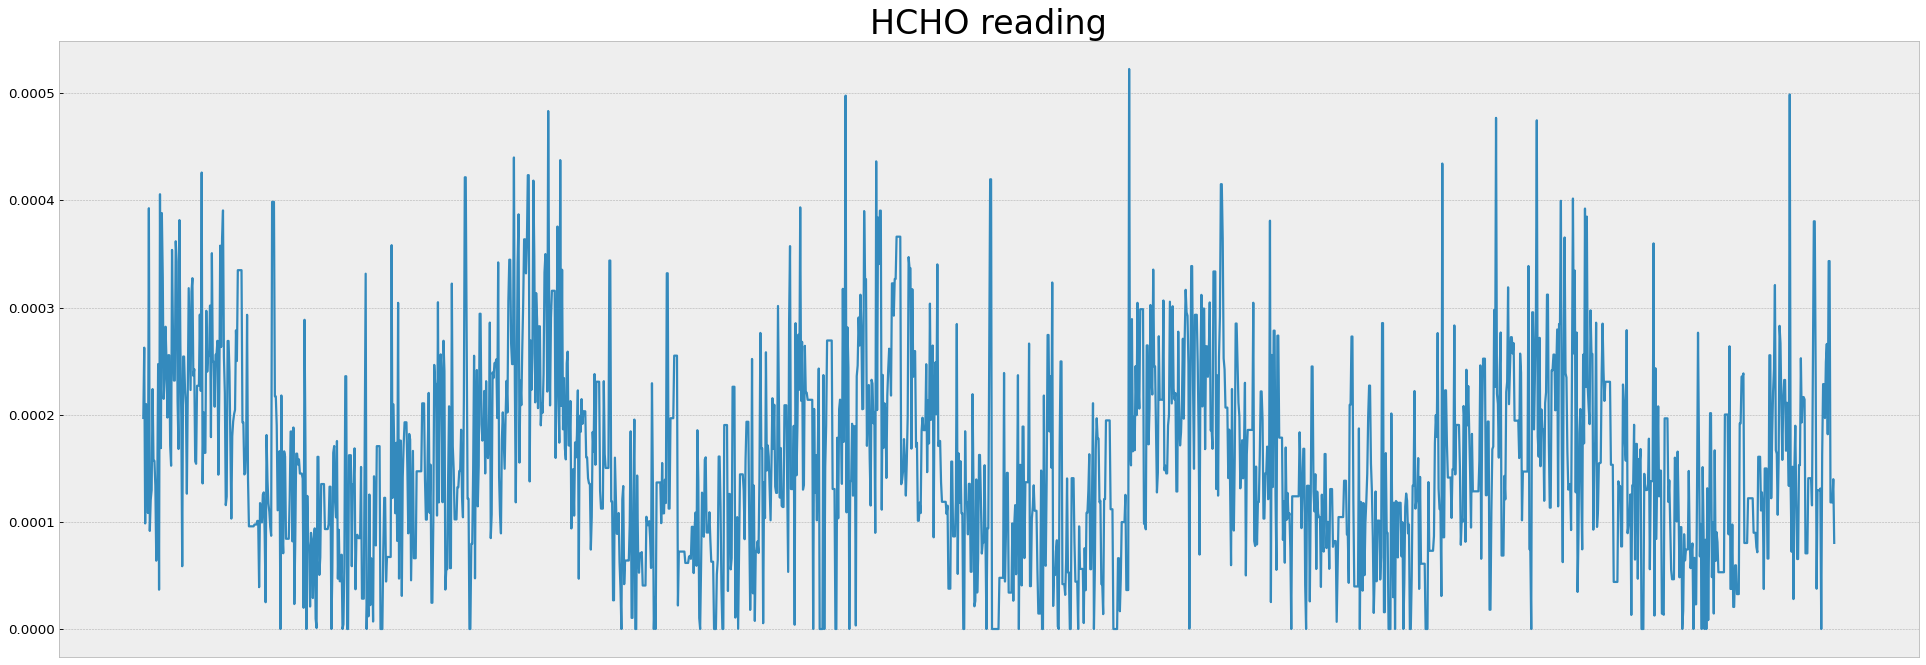

In [31]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('HCHO reading', fontsize=30)
plt.plot(colombo_df['HCHO reading'])
plt.xticks([])  # Remove x-axis ticks
plt.show()